[0.1198884865134865, 0.11815975398870134, 0.11643102146391619, 0.11470228893913102, 0.11297355641434594, 0.11124482388956074, 0.10951609136477555, 0.10778735883999042, 0.10605862631520527, 0.1043298937904201, 0.10264794489136596, 0.10109784075573548, 0.09965406304222092, 0.09821028532870636, 0.09681036726431463, 0.09555664803033224, 0.09433216856243173, 0.09310768909453121, 0.09206502780844886, 0.09102236652236652] [0.13410170554571338, 0.13268569929496907, 0.13150628264438383, 0.13056986697901637, 0.12988170833999435, 0.129445766134457, 0.1292645921719539, 0.12933925706857324, 0.12966931888131145, 0.13025283609065808, 0.13104979310642292, 0.13199300555927357, 0.13310308013833944, 0.13445703634467138, 0.13601638630546362, 0.13770453369397298, 0.13959984895730884, 0.1417139922544915, 0.14392118253128455, 0.14633434634184125]
0.746781725263849


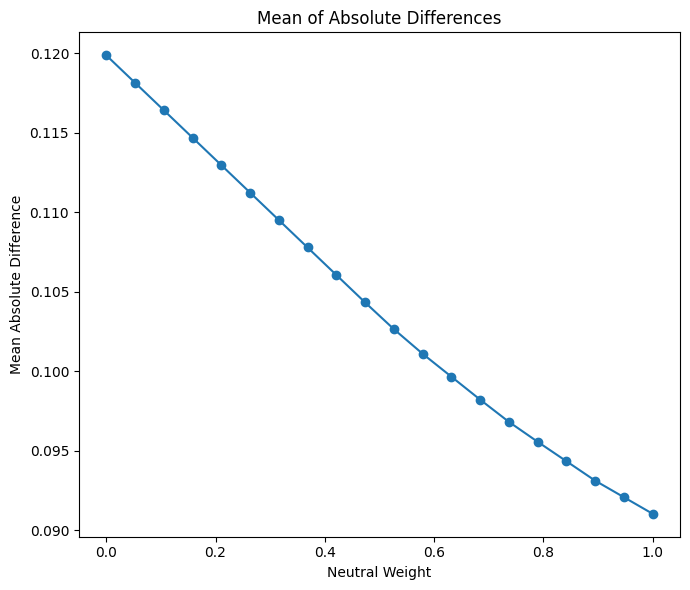

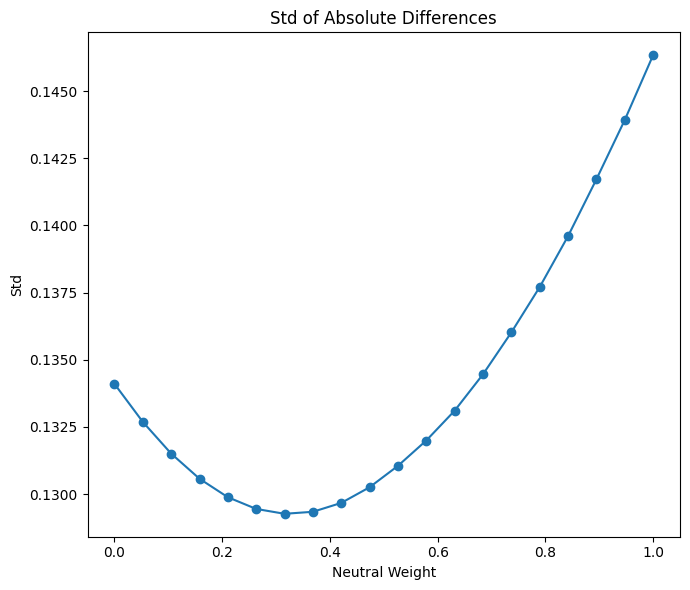

In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 加载数据
def load_data():
    with open('data/complex/raw_ori.json') as f:
        ori = json.load(f)
    with open('data/complex/raw_mod.json') as f:
        mod = json.load(f)
    with open('data/complex/checked_ori.json') as f:
        ori_rc = json.load(f)
    with open('data/complex/checked_mod.json') as f:
        mod_rc = json.load(f)

    return ori, mod, ori_rc, mod_rc

# 计算相似性分数
def calculate_similarities(ori, mod, ori_rc, mod_rc, neutral_weight):
    ori_claims = [o['claims'] for o in ori.values()]
    if len(ori_claims) == 1:
        ori_claims = ori_claims[0]
    ori_len = len(ori_claims)
    mod_claims = [m['claims'] for m in mod.values()]
    mod_len = [len(l) for l in mod_claims]
    mod_op = [m['operations'] for m in mod.values()]

    score_map = {
        1: neutral_weight - 1,
        2: -2,
        3: 0,
        4: 2 * neutral_weight,
        5: neutral_weight - 1,
        6: 0
    }
    scores = [sum(score_map[i] for i in o) for o in mod_op]
    
    gt_sim = [(ori_len + mod_len[i] + scores[i]) / (ori_len + mod_len[i]) for i in range(len(scores))]

    ori_labels_rc = [o['labels'] for o in ori_rc.values()][0]
    mod_labels_rc = [m['labels'] for m in mod_rc.values()]

    weight_map = {
        'Entailment': 1,
        'Contradiction': 0,
        'Neutral': neutral_weight
    }

    rc_sim = []
    for i in range(len(mod_labels_rc)):
        length = len(ori_labels_rc) + len(mod_labels_rc[i])
        weight = sum(weight_map.get(label_ori[i], 0) for label_ori in ori_labels_rc)
        weight += sum(weight_map.get(labels, 0) for labels in mod_labels_rc[i])
        sim = weight / length
        rc_sim.append(sim)

    abs_diff = np.abs(np.array(gt_sim) - np.array(rc_sim))
    np.save('./data/complex/gt_sim.npy', gt_sim)    
    mean = np.mean(abs_diff)
    std = np.std(abs_diff)
    per, _ = pearsonr(gt_sim, rc_sim)  
    
    return mean, std, per

# 主执行函数
def main():
    ori, mod, ori_rc, mod_rc = load_data()
    neutral_weights = np.linspace(0, 1, 20)
    means, stds = [], []

    for nw in neutral_weights:
        mean, std, per = calculate_similarities(ori, mod, ori_rc, mod_rc, nw)
        means.append(mean)
        stds.append(std)
    
    print(means, stds)
    print(per)

    # 绘制第一个图并保存
    plt.figure(figsize=(7, 6))
    plt.plot(neutral_weights, means, marker='o', linestyle='-')
    plt.title('Mean of Absolute Differences')
    plt.xlabel('Neutral Weight')
    plt.ylabel('Mean Absolute Difference')
    plt.tight_layout()
    plt.savefig('mean_absolute_diff.pdf', format='pdf')
    plt.show()

    # 绘制第二个图并保存
    plt.figure(figsize=(7, 6))
    plt.plot(neutral_weights, stds, marker='o', linestyle='-')
    plt.title('Std of Absolute Differences')
    plt.xlabel('Neutral Weight')
    plt.ylabel('Std')
    plt.tight_layout()
    plt.savefig('std_absolute_diff.pdf', format='pdf')
    plt.show()

if __name__ == '__main__':
    main()


BoW

In [38]:
import json
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Paths to the data files
ref_path = './data/complex/raw_ori.json'
gt_sim_path = './data/complex/gt_sim.npy'
txt_path = './data/complex/raw_mod.json'

# Load the ground truth similarities
gt_sim = np.load(gt_sim_path)

# Load and process the reference responses
with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

# Load and process the modified responses
with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Compute BoW cosine similarities
bow_sim = []
for t in texts:
    vectors = vectorizer.fit_transform([ori, t])
    cosine_sim = cosine_similarity(vectors[0], vectors[1])
    bow_sim.append(cosine_sim[0, 0])  # Extract scalar value

# Convert lists to numpy arrays
bow_sim = np.array(bow_sim)

# Calculate absolute differences
abs_diff = np.abs(gt_sim - bow_sim)

# Compute mean and standard deviation of absolute differences
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Check for constant arrays
if np.all(gt_sim == gt_sim[0]) or np.all(bow_sim == bow_sim[0]):
    print("One or both arrays are constant; Pearson correlation cannot be computed.")
else:
    # Compute Pearson correlation coefficient
    per, _ = pearsonr(gt_sim, bow_sim)
    print(f'Pearson correlation coefficient: {per}')

# Print results
print(f'BoW similarities: {bow_sim}')
print(f'Ground truth similarities: {gt_sim}')
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')


Pearson correlation coefficient: -0.27236867480291616
BoW similarities: [0.84895272 0.74877678 0.86962636 0.87332606 0.90142131 0.83156675
 0.96386319 0.91205712 0.85715939 0.94218094 0.94329996 0.95210841
 0.90142131 0.95759132 0.89527379 0.95346259 0.95214228 0.79611324
 0.78772636 0.94475611 0.86094603 0.89527379 0.82928843 0.94329996
 0.90802522 0.82951506 0.87787623 0.85634884 0.9        0.61753478
 0.8894934  0.95801702 0.83010486 0.88755868 0.98373875 0.93127185
 0.91273048 0.91983354 0.91756438 0.91306109 0.82541281 0.84678039
 0.85539892 0.96086423 0.94329996 0.74535599 0.83550998 0.90053899
 0.84327404 0.93250481 0.96666667 0.78894105 0.95668077 0.82683551
 0.67241115 0.9412097  0.92710507 0.91983354 0.79582243 0.85865051
 0.91901409 0.8811039  0.85298051 0.74535599 0.95262794 0.9005359
 0.92212497 0.94547285 0.87038828 0.90932667 0.88022349 0.9253116
 0.73771111 0.86469203 0.87017654 0.91146543 0.88544283 0.92195445
 0.96666667 0.95801702 0.90270757 0.86066297 0.91473626 0.8

TF-IDF

In [39]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim_path = './data/complex/gt_sim.npy'
txt_path = './data/complex/raw_mod.json'

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Load ground truth similarities
gt_sim = np.load(gt_sim_path)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Compute TF-IDF and cosine similarity
tf_sim = []
for t in texts:
    vectors = vectorizer.fit_transform([ori, t])
    cosine_sim = cosine_similarity(vectors[0], vectors[1])
    tf_sim.append(cosine_sim[0, 0])  # Extract scalar value

# Convert to numpy arrays
gt_sim = np.array(gt_sim)
tf_sim = np.array(tf_sim)

# Calculate absolute differences
abs_diff = np.abs(gt_sim - tf_sim)

# Calculate mean and standard deviation of absolute differences
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Calculate Pearson correlation coefficient
if len(gt_sim) == len(tf_sim) and len(gt_sim) > 1:  # Ensure both arrays have the same length and more than one value
    pearson_corr, _ = pearsonr(gt_sim, tf_sim)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')


Pearson correlation coefficient: -0.26911927882350495
Mean absolute difference: 0.2426205788488401
Standard deviation of absolute difference: 0.2007317648087443


n-gram

In [40]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim_path = './data/complex/gt_sim.npy'
txt_path = './data/complex/raw_mod.json'

# Load ground truth similarities
gt_sim = np.load(gt_sim_path)

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Define Jaccard similarity function
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Use TfidfVectorizer to extract n-gram features
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))

# Calculate Jaccard similarity for each text
ngram_sim = []
for t in texts:
    ori_ngrams = set(vectorizer.fit([ori]).get_feature_names_out())
    text_ngrams = set(vectorizer.fit([t]).get_feature_names_out())
    
    # Calculate Jaccard similarity
    jaccard_sim = jaccard_similarity(ori_ngrams, text_ngrams)
    ngram_sim.append(jaccard_sim)

# Convert to numpy arrays
ngram_sim = np.array(ngram_sim)
gt_sim = np.array(gt_sim)

# Calculate absolute differences
abs_diff = np.abs(gt_sim - ngram_sim)

# Calculate mean and standard deviation of absolute differences
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Calculate Pearson correlation coefficient
if len(gt_sim) == len(ngram_sim) and len(gt_sim) > 1:  # Ensure both arrays have the same length and more than one value
    pearson_corr, _ = pearsonr(gt_sim, ngram_sim)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')



Pearson correlation coefficient: -0.3669716908755478
Mean absolute difference: 0.3112502890212578
Standard deviation of absolute difference: 0.24015185102870687


Sim CSE

In [36]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import logging

# Suppress warnings
logging.basicConfig(level=logging.ERROR)

# Initialize an empty list to store cosine similarities
cse_sim = []

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim_path = './data/complex/gt_sim.npy'
txt_path = './data/complex/raw_mod.json'

# Load ground truth similarities
gt_sim = np.load(gt_sim_path)

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Load SimCSE model and tokenizer
model_name = "princeton-nlp/sup-simcse-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings from the SimCSE model
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the last hidden state as the sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Calculate cosine similarity for each text
for t in texts:
    ori_embedding = get_embedding(ori)
    text_embedding = get_embedding(t)
    
    cosine_sim = cosine_similarity(ori_embedding, text_embedding)
    cse_sim.append(cosine_sim[0, 0])  # Extract scalar value

# Convert lists to numpy arrays
cse_sim = np.array(cse_sim)

# Calculate absolute differences
abs_diff = np.abs(gt_sim - cse_sim)

# Calculate mean and standard deviation of absolute differences
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Calculate Pearson correlation coefficient
if len(gt_sim) == len(cse_sim) and len(gt_sim) > 1:  # Ensure both arrays have the same length and more than one value
    pearson_corr, _ = pearsonr(gt_sim, cse_sim)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')


Pearson correlation coefficient: 0.39854721084692973
Mean absolute difference: 0.15961000070186576
Standard deviation of absolute difference: 0.1625878845345877


In [41]:
import json
import numpy as np
import bert_score
from scipy.stats import pearsonr
import logging
logging.basicConfig(level=logging.ERROR)

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim = np.load('./data/complex/gt_sim.npy')

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

txt_path = './data/complex/raw_mod.json'
with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Compute BERTScore
P, R, F1 = bert_score.score([ori] * len(texts), texts, lang='en', verbose=True)
bert_scores = F1.numpy()

# Calculate absolute differences
abs_diff = np.abs(np.array(gt_sim) - np.array(bert_scores))

# Compute statistics
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Calculate Pearson correlation
if len(gt_sim) == len(bert_scores) and len(gt_sim) > 1:
    pearson_corr, _ = pearsonr(gt_sim, bert_scores)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    pearson_corr = None
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')

# Save results
np.save('./data/complex/bert_scores.npy', [mean, std, pearson_corr])


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00, 126.47it/s]

done in 0.23 seconds, 437.56 sentences/sec
Pearson correlation coefficient: -0.1579691131023182
Mean absolute difference: 0.1652306723847534
Standard deviation of absolute difference: 0.16014672180374817


In [42]:
import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from scipy.stats import pearsonr
from tqdm import tqdm

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim = np.load('./data/complex/gt_sim.npy')

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

txt_path = './data/complex/raw_mod.json'
with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
ori_embedding = model.encode(ori, convert_to_tensor=True)
text_embeddings = model.encode(texts, convert_to_tensor=True)

# Compute similarities
sentence_similarities = []
for text_embedding in tqdm(text_embeddings, desc='Computing Sentence-BERT Similarities'):
    similarity = util.pytorch_cos_sim(ori_embedding, text_embedding).item()
    sentence_similarities.append(similarity)

# Calculate absolute differences
abs_diff = np.abs(np.array(gt_sim) - np.array(sentence_similarities))

# Compute statistics
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Compute Pearson correlation
if len(gt_sim) == len(sentence_similarities) and len(gt_sim) > 1:
    pearson_corr, _ = pearsonr(gt_sim, sentence_similarities)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    pearson_corr = None
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')



/opt/conda/envs/refchecker/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing Sentence-BERT Similarities: 100%|██████████| 100/100 [00:00<00:00, 7782.94it/s]

Pearson correlation coefficient: 0.005182576973373667
Mean absolute difference: 0.19810796382571713
Standard deviation of absolute difference: 0.1815394141366089


In [43]:
import json
import numpy as np
import gensim.downloader as api
from gensim.similarities import WmdSimilarity
from scipy.stats import pearsonr
from tqdm import tqdm

# Load data
ref_path = './data/complex/raw_ori.json'
gt_sim = np.load('./data/complex/gt_sim.npy')

with open(ref_path) as f:
    ref = json.load(f)
ori = ref['0']['response']

txt_path = './data/complex/raw_mod.json'
with open(txt_path) as f:
    txt = json.load(f)

texts = [d['response'] for d in txt.values()]

# Load pre-trained word embeddings
print("Loading pre-trained word embeddings...")
model = api.load("glove-wiki-gigaword-100")  # You can also use "word2vec-google-news-300"

# Prepare WMD similarity instance
print("Preparing WMD similarity...")
wmd_instance = WmdSimilarity([ori], model)

# Compute WMD similarities
wmd_similarities = []
for text in tqdm(texts, desc='Computing WMD Similarities'):
    similarity = wmd_instance[text]
    wmd_similarities.append(similarity[0])  # similarity[0] corresponds to the WMD score

# Calculate absolute differences
abs_diff = np.abs(np.array(gt_sim) - np.array(wmd_similarities))

# Compute statistics
mean = np.mean(abs_diff)
std = np.std(abs_diff)

# Compute Pearson correlation
if len(gt_sim) == len(wmd_similarities) and len(gt_sim) > 1:
    pearson_corr, _ = pearsonr(gt_sim, wmd_similarities)
    print(f'Pearson correlation coefficient: {pearson_corr}')
else:
    pearson_corr = None
    print("Cannot compute Pearson correlation. Ensure both arrays have the same length and more than one value.")

# Print results
print(f'Mean absolute difference: {mean}')
print(f'Standard deviation of absolute difference: {std}')

# Save the results
np.save('./data/complex/wmd_scores.npy', [mean, std, pearson_corr])


Loading pre-trained word embeddings...


Preparing WMD similarity...


Computing WMD Similarities: 100%|██████████| 100/100 [00:00<00:00, 789.39it/s]

Pearson correlation coefficient: -0.3260353331798333
Mean absolute difference: 0.17757928161235398
Standard deviation of absolute difference: 0.15685795993495708
